# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных
Данные геологоразведки трёх регионов находятся в файлах: 
* /datasets/geo_data_0.csv
* /datasets/geo_data_1.csv
* /datasets/geo_data_2.csv

* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [1]:
!pip install -q phik

In [2]:
from scipy import stats as st

import matplotlib
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    recall_score,
    r2_score,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay,
    make_scorer
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [3]:
RANDOM_STATE = 42

In [4]:
data_geo1 = pd.read_csv("/datasets/geo_data_0.csv")
data_geo2 = pd.read_csv("/datasets/geo_data_1.csv")
data_geo3 = pd.read_csv("/datasets/geo_data_2.csv")

In [5]:
display(data_geo1.head())
display(data_geo2.head())
display(data_geo3.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [6]:
data_geo1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
data_geo2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
data_geo3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**Итоги по обзору данных:**
* Никаких проблем с названиями и форматом столбцов 
* Формат данных соответствует описанию датасета

# Предобработка данных


In [9]:
data_geo1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [10]:
data_geo2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [11]:
data_geo3.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

**Пропуски не обнаружены**

In [12]:
data_geo1.duplicated().sum()

0

In [13]:
data_geo2.duplicated().sum()

0

In [14]:
data_geo3.duplicated().sum()

0

**Явные дубликаты отсутствуют**

In [15]:
display(data_geo1["id"].duplicated().sum())

10

In [16]:
display(data_geo1.loc[data_geo1["id"].duplicated()])

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


In [17]:
def print_duplicated(data):
    for each in list(data.loc[data["id"].duplicated()]["id"]):
        display(data.loc[data["id"] == each])
        

In [18]:
print_duplicated(data_geo1)

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695


,id,f0,f1,f2,product
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798


,id,f0,f1,f2,product
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


,id,f0,f1,f2,product
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675


,id,f0,f1,f2,product
64022,74z30,0.741456,0.459229,5.153109,140.771492
66136,74z30,1.084962,-0.312358,6.990771,127.643327


,id,f0,f1,f2,product
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453


,id,f0,f1,f2,product
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
75715,Tdehs,0.112079,0.430296,3.218993,60.964018


,id,f0,f1,f2,product
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
90815,fiKDv,0.049883,0.841313,6.394613,137.346586


,id,f0,f1,f2,product
60140,TtcGQ,0.569276,-0.104876,6.440215,85.350186
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008


,id,f0,f1,f2,product
89582,bsk9y,0.398908,-0.400253,10.122376,163.433078
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


При изучении неявных дубликатов, аномальные значения и причины для дубликатов найдены не были. По этой причине, можно смело удалять дубликаты из-за их малого количества относительно общего сета данных.

In [19]:
print_duplicated(data_geo2)

,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625


,id,f0,f1,f2,product
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886


,id,f0,f1,f2,product
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


In [20]:
print_duplicated(data_geo3)

,id,f0,f1,f2,product
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802


,id,f0,f1,f2,product
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


In [21]:
data_geo1 = data_geo1.drop_duplicates(subset='id').reset_index(drop=True)
data_geo2 = data_geo2.drop_duplicates(subset='id').reset_index(drop=True)
data_geo3 = data_geo3.drop_duplicates(subset='id').reset_index(drop=True)

In [22]:
data_geo1.info()
data_geo2.info()
data_geo3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99990 entries, 0 to 99989
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99990 non-null  object 
 1   f0       99990 non-null  float64
 2   f1       99990 non-null  float64
 3   f2       99990 non-null  float64
 4   product  99990 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99996 entries, 0 to 99995
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99996 entries, 0 to 99995
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
--

**Итоги по предобработке данных:**
* Пропусков нет
* Неявные дубликаты были обработаны
* Явных дубликатов нет

# Исследовательский анализ данных

In [83]:
def plot_hist(data, name, number, x_beg = None, x_end = None):
    data[name].plot(kind="hist", bins = number, figsize=(8,5), title=f"Гистограмма для '{name}'", grid = True, edgecolor = "black")
    plt.xlabel(f"{name}")
    plt.ylabel("Частота")
    if x_beg is not None and x_end is not None:
        plt.xlim(x_beg, x_end)
    plt.show()

In [24]:
def plot_box(data, name, lower, upper):
    plt.ylim(lower, upper)
    data.boxplot(name)

In [25]:
def plot_pie(data, name):
    count = data[name].value_counts()
    plt.figure(figsize=(10, 5))
    count.plot(kind="pie", autopct="%1.1f%%", startangle=90)
    plt.title(f"Круговая диаграмма для '{name}'")
    plt.ylabel('')
    plt.show()

In [26]:
data_geo1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99990 entries, 0 to 99989
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99990 non-null  object 
 1   f0       99990 non-null  float64
 2   f1       99990 non-null  float64
 3   f2       99990 non-null  float64
 4   product  99990 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


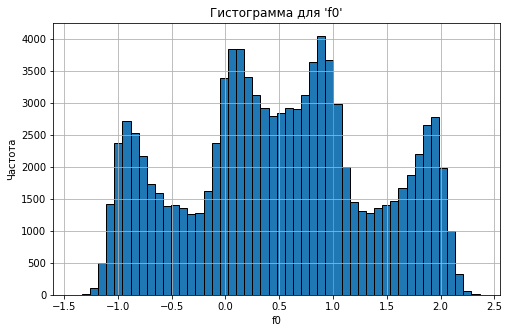

count    99990.000000
mean         0.500454
std          0.871844
min         -1.408605
25%         -0.072572
50%          0.502405
75%          1.073626
max          2.362331
Name: f0, dtype: float64

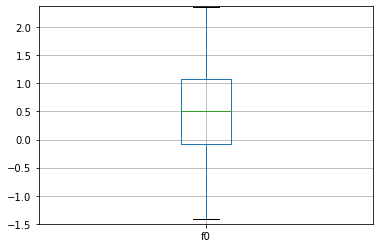

In [27]:
plot_hist(data_geo1, "f0", 50)
plot_box(data_geo1, "f0", -1.5, 2.37)
data_geo1["f0"].describe()

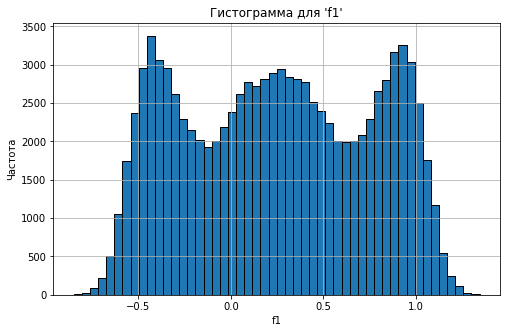

count    99990.000000
mean         0.250141
std          0.504430
min         -0.848218
25%         -0.200877
50%          0.250252
75%          0.700640
max          1.343769
Name: f1, dtype: float64

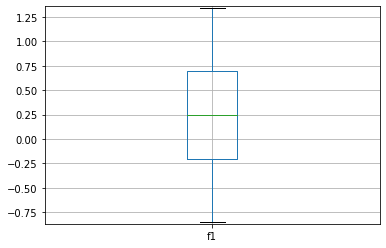

In [28]:
plot_hist(data_geo1, "f1", 50)
plot_box(data_geo1, "f1", -0.87, 1.36)
data_geo1["f1"].describe()

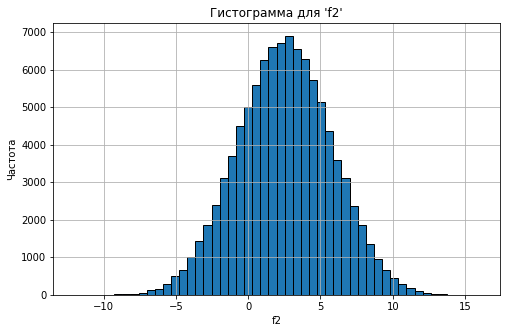

count    99990.000000
mean         2.502629
std          3.248149
min        -12.088328
25%          0.287784
50%          2.515969
75%          4.715035
max         16.003790
Name: f2, dtype: float64

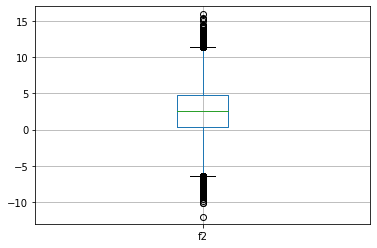

In [29]:
plot_hist(data_geo1, "f2", 50)
plot_box(data_geo1, "f2", -13, 17)
data_geo1["f2"].describe()

Так как нам неизвестна природа значений f0, f1 и f2, то нам затруднительно провести анализ этих значений. F0 имеет 4 выраженных пика на отметках -1, 0, 1 и 2. Среднее значение и медиана находятся на отметке 0.5. В свою очередь график F2 имеет 3 пика: 0.25, что также является медианой и средним значением, --0.5 и 1. График F2 имеет только один пик на отметке 2.5, что также является медианой и средним значением. Значения в этих столбцах данных имеют разный диапазон, что означает для выявления зависимости надо будет провести масштабирование данных.

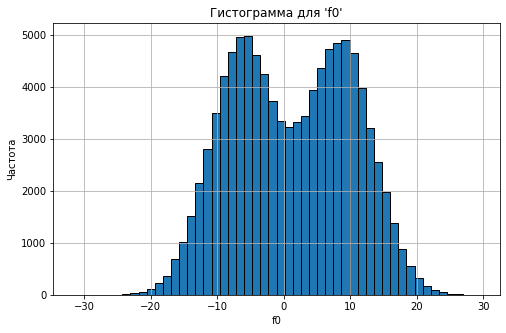

count    99996.000000
mean         1.141209
std          8.965815
min        -31.609576
25%         -6.298551
50%          1.153055
75%          8.620964
max         29.421755
Name: f0, dtype: float64

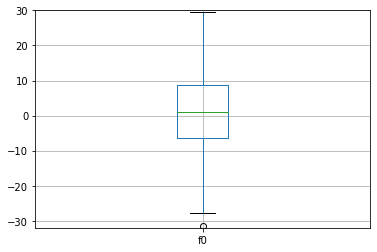

In [30]:
plot_hist(data_geo2, "f0", 50)
plot_box(data_geo2, "f0", -32, 30)
data_geo2["f0"].describe()

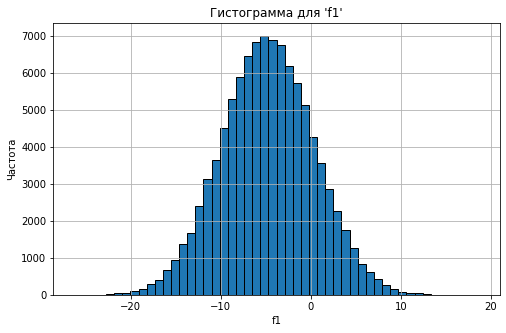

count    99996.000000
mean        -4.796608
std          5.119906
min        -26.358598
25%         -8.267985
50%         -4.813172
75%         -1.332816
max         18.734063
Name: f1, dtype: float64

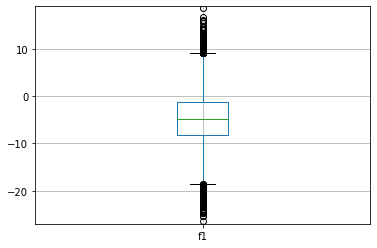

In [31]:
plot_hist(data_geo2, "f1", 50)
plot_box(data_geo2, "f1", -27, 19)
data_geo2["f1"].describe()

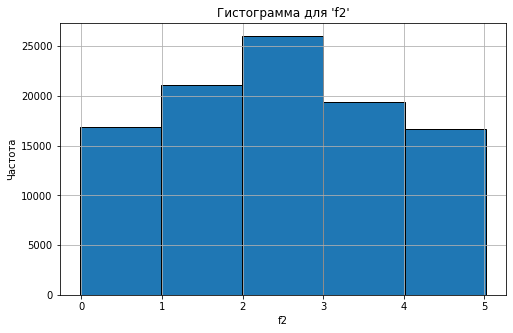

count    99996.000000
mean         2.494501
std          1.703579
min         -0.018144
25%          1.000021
50%          2.011475
75%          3.999904
max          5.019721
Name: f2, dtype: float64

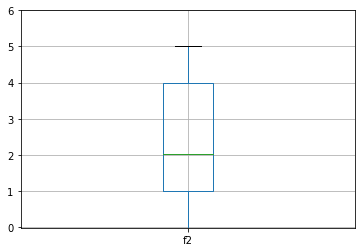

In [32]:
plot_hist(data_geo2, "f2", 5)
plot_box(data_geo2, "f2", -0.02, 6)
data_geo2["f2"].describe()

Значения для второй скважины имеют другую природу, но в целом ничего каардинально отличного и примечательного. Все еще трудно выявить какие-то закономерности и причины для выбросов без информации о самих данных.

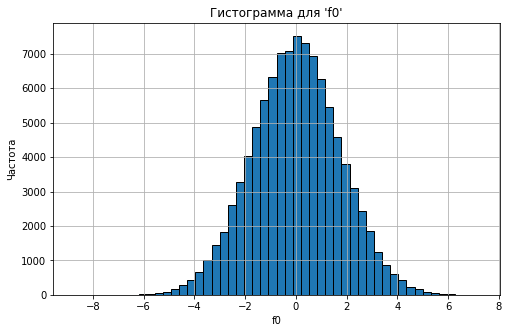

count    99996.000000
mean         0.002002
std          1.732052
min         -8.760004
25%         -1.162328
50%          0.009424
75%          1.158477
max          7.238262
Name: f0, dtype: float64

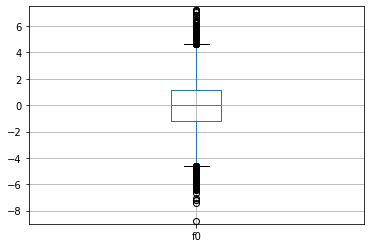

In [33]:
plot_hist(data_geo3, "f0", 50)
plot_box(data_geo3, "f0", -9, 7.5)
data_geo3["f0"].describe()

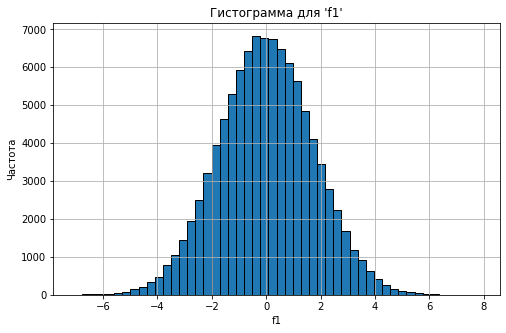

count    99996.000000
mean        -0.002159
std          1.730397
min         -7.084020
25%         -1.174841
50%         -0.009661
75%          1.163523
max          7.844801
Name: f1, dtype: float64

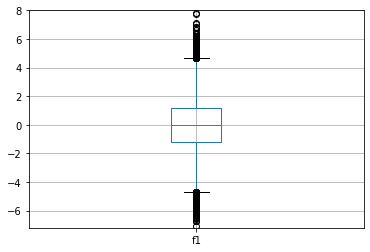

In [34]:
plot_hist(data_geo3, "f1", 50)
plot_box(data_geo3, "f1", -7.2, 8)
data_geo3["f1"].describe()

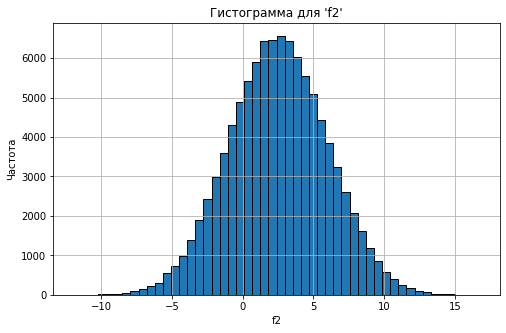

count    99996.000000
mean         2.495084
std          3.473482
min        -11.970335
25%          0.130269
50%          2.484236
75%          4.858720
max         16.739402
Name: f2, dtype: float64

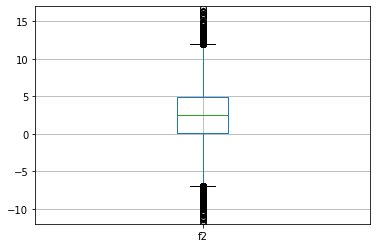

In [35]:
plot_hist(data_geo3, "f2", 50)
plot_box(data_geo3, "f2", -12, 17)
data_geo3["f2"].describe()

Точно также как и с остальными регионами

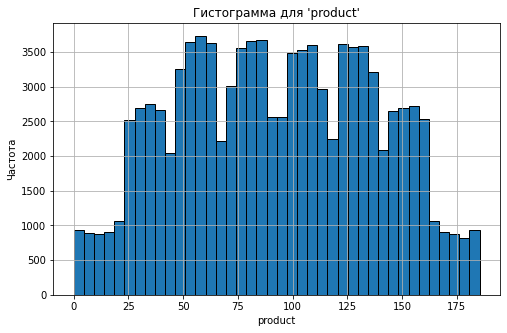

count    99990.000000
mean        92.499684
std         44.288304
min          0.000000
25%         56.497069
50%         91.847928
75%        128.563699
max        185.364347
Name: product, dtype: float64

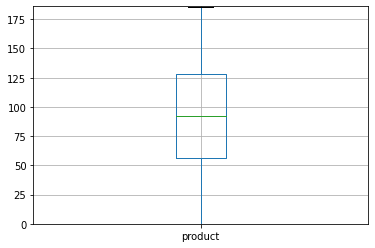

In [36]:
plot_hist(data_geo1, "product", 40)
plot_box(data_geo1, "product", 0, 186)
data_geo1["product"].describe()

В первом регионе среднее значение и медиана объема равны приблизительно 92 тысячам баррелелям. Максимальное значение 185, а минимальное равно 0.

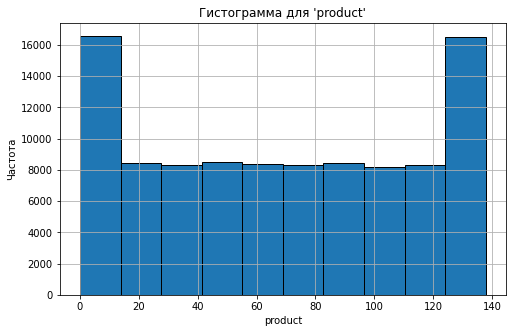

count    99996.000000
mean        68.823916
std         45.944663
min          0.000000
25%         26.953261
50%         57.085625
75%        107.813044
max        137.945408
Name: product, dtype: float64

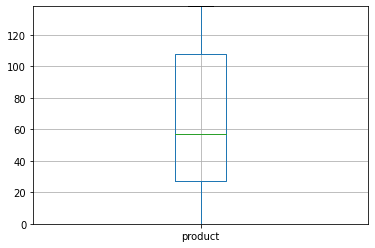

In [37]:
plot_hist(data_geo2, "product", 10)
plot_box(data_geo2, "product", 0, 138)
data_geo2["product"].describe()

Во втором регионе среднее значение равно 57, а медиана приблизительно 69 тысячам баррелелям. Максимальное значение 137, а минимальное равно 0.

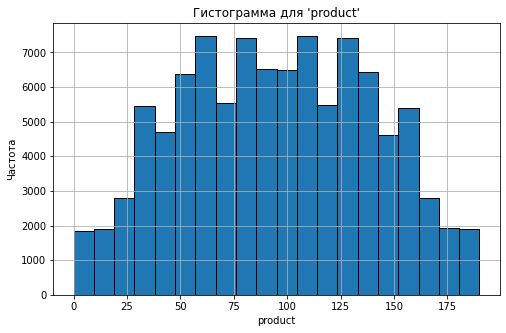

count    99996.000000
mean        94.998342
std         44.749573
min          0.000000
25%         59.450028
50%         94.925026
75%        130.586815
max        190.029838
Name: product, dtype: float64

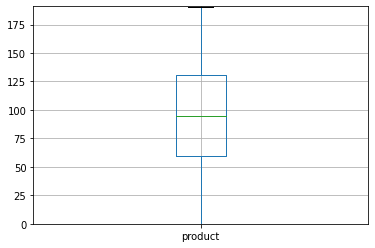

In [38]:
plot_hist(data_geo3, "product", 20)
plot_box(data_geo3, "product", 0, 191)
data_geo3["product"].describe()

В третьем регионе среднее значение и медиана объема равны приблизительно 94 тысячам баррелелям. Максимальное значение 190, а минимальное равно 0.

**Итоги по исследовательскому анализу данных:**
* Трудно определить закономерности и причину выбросов для значений f0, f1 и f2 из-за неизвестной природы
* В первом регионе среднее значение и медиана объема равны приблизительно 92 тысячам баррелелям. Максимальное значение 185, а минимальное равно 0.
* Во втором регионе среднее значение равно 57, а медиана приблизительно 69 тысячам баррелелям. Максимальное значение 137, а минимальное равно 0.
* В третьем регионе среднее значение и медиана объема равны приблизительно 94 тысячам баррелелям. Максимальное значение 190, а минимальное равно 0.
* Регионом с самым большим средним и общим значением является 3 регион. На втором месте находиться первый регион, а третий регион имеет самое большое количество выбросов, так как медиана и среднее значение разительно отличаются.


# Корреляционный анализ признаков


In [39]:
num_cols = []

In [40]:
for col in data_geo1.columns:
    if ((data_geo1[col].dtype == 'int64' or data_geo1[col].dtype == 'float64') and (col != 'id')):
        num_cols.append(col)

In [41]:
phik_train = data_geo1.drop(columns = "id")

In [42]:
phik_overview = phik_train.phik_matrix(interval_cols=num_cols)

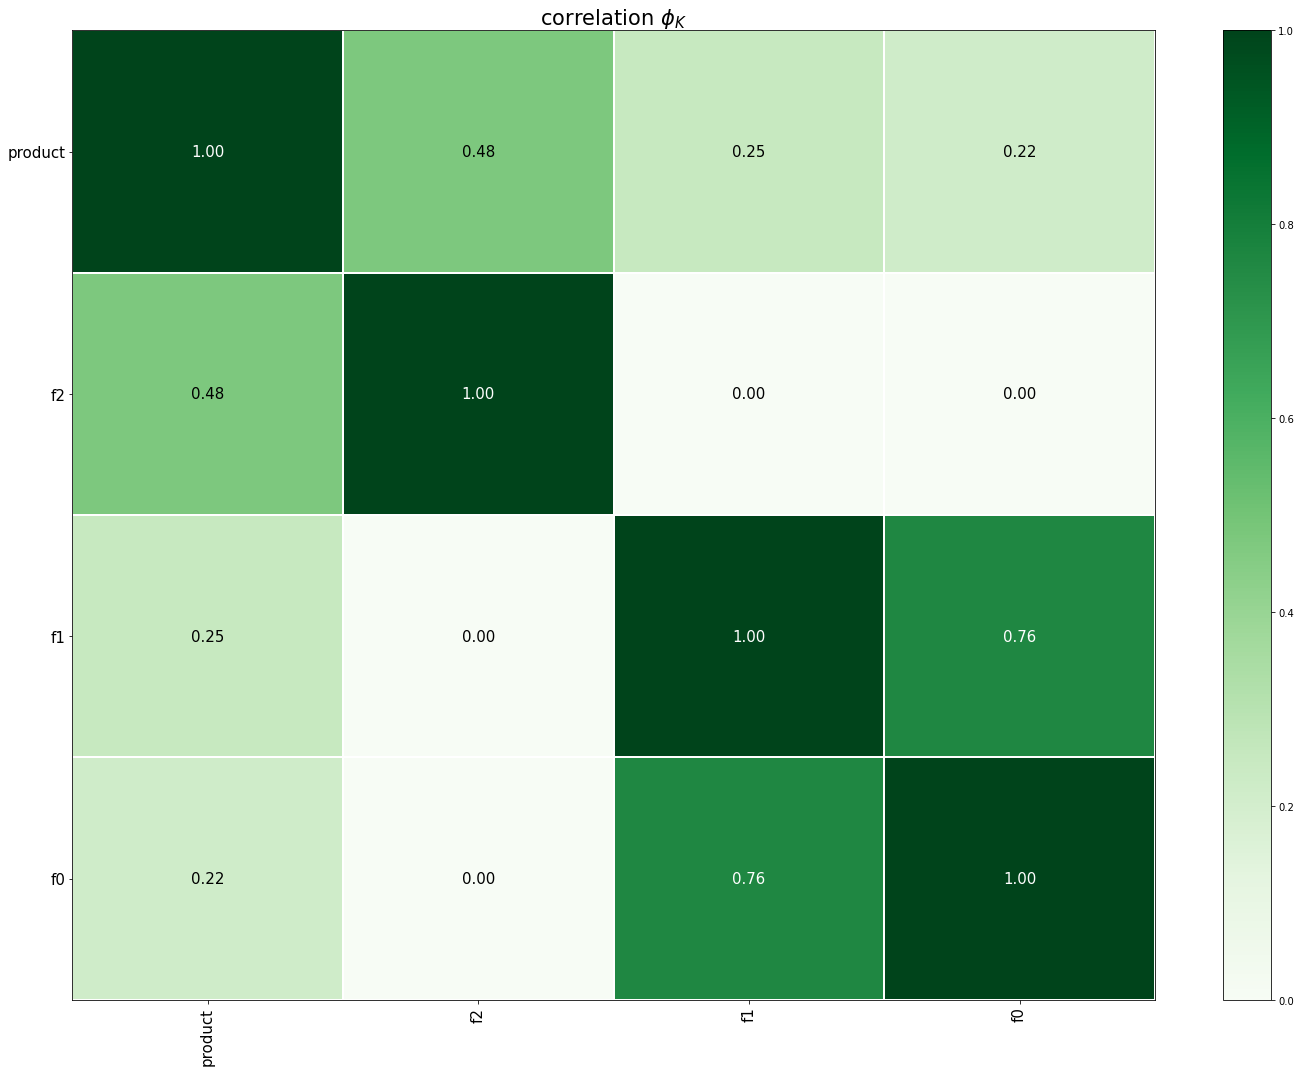

In [43]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Корреляционный анализ анализ признаков первого региона показывает, что целевой признак больше всего зависит от f2. Коэффициент равен 0.48. Тем не менее, сильной такую связь назвать сложно. Примечательно, что f2 вообще не зависит от других признаков. Между f1 и f2 присутствует сильная связь с коэффициентом 0.76. 

In [44]:
phik_train = data_geo2.drop(columns = "id")
phik_overview = phik_train.phik_matrix(interval_cols=num_cols)

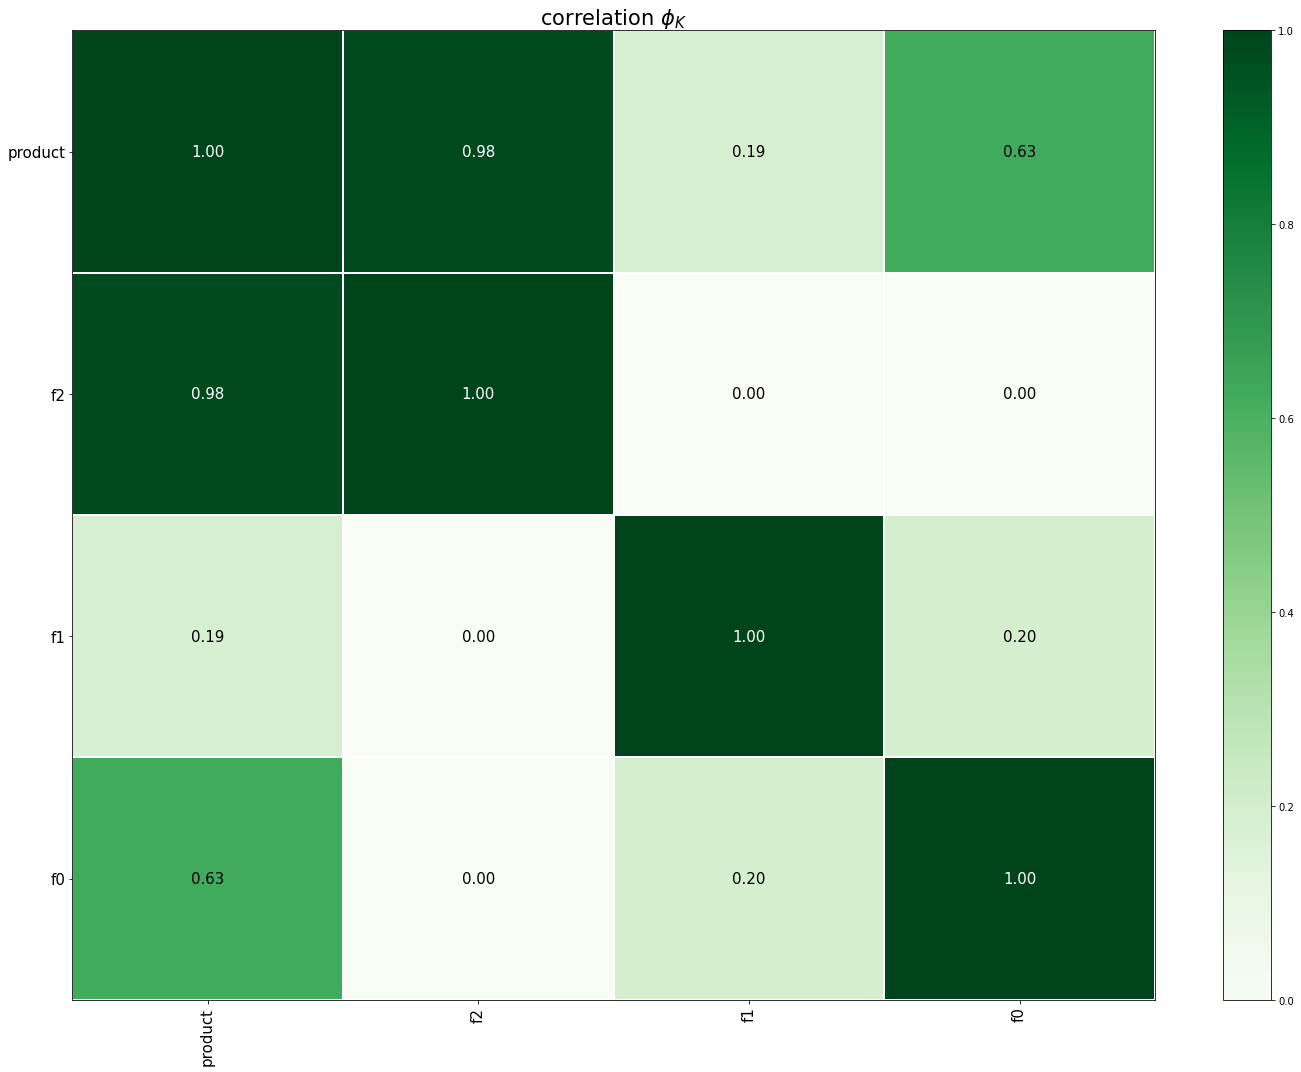

In [45]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Корреляционный анализ анализ признаков второго региона показывает, что целевой признак больше всего зависит от f2. Коэффициент равен 0.98. Целевой признак практически полностью зависит от f2, что может привести к переобучении модели. Целевой признак также имеет сильную связь с f0 - 0.63. 

In [46]:
phik_train = data_geo3.drop(columns = "id")
phik_overview = phik_train.phik_matrix(interval_cols=num_cols)

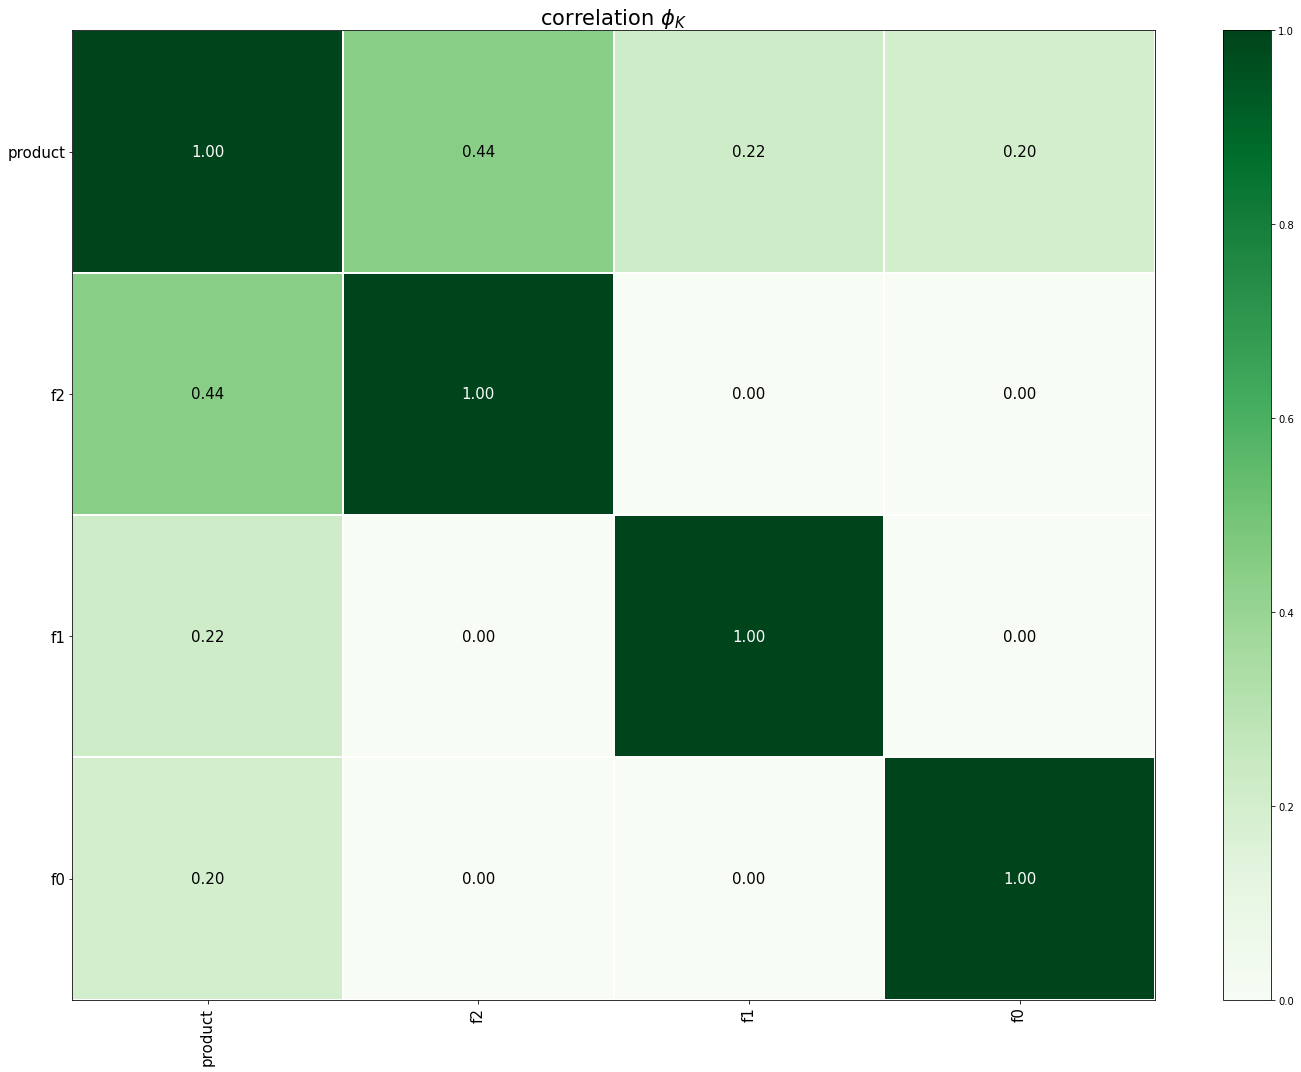

In [47]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Корреляционный анализ анализ признаков второго региона показывает, что целевой признак больше всего зависит от f2. Коэффициент равен 0.44. С остальными же признаками связь слабая - 0.22 и 0.20. Примечательно, что признаки не зависят друг от друга и имею коэффициент равен 0.

**Итоги по корреляционному анализу признаков:**
* Корреляционный анализ анализ признаков первого региона показывает, что целевой признак больше всего зависит от f2. Коэффициент равен 0.48. Тем не менее, сильной такую связь назвать сложно. Примечательно, что f2 вообще не зависит от других признаков. Между f1 и f2 присутствует сильная связь с коэффициентом 0.76. 
* Корреляционный анализ анализ признаков второго региона показывает, что целевой признак больше всего зависит от f2. Коэффициент равен 0.98. Целевой признак практически полностью зависит от f2, что может привести к переобучении модели. Целевой признак также имеет сильную связь с f0 - 0.63. 
* Корреляционный анализ анализ признаков второго региона показывает, что целевой признак больше всего зависит от f2. Коэффициент равен 0.44. С остальными же признаками связь слабая - 0.22 и 0.20. Примечательно, что признаки не зависят друг от друга и имею коэффициент равен 0.

## Обучение и проверка модели

In [48]:
def linear_regression(data):
    X = data.drop(columns={"id", "product"})
    y = data["product"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE, test_size = 0.25)
    num_col_names = ["f0", "f1", "f2"]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[num_col_names])
    X_test_scaled = scaler.transform(X_test[num_col_names])
    model_lr  = LinearRegression()
    model_lr.fit(X_train_scaled, y_train)
    predictions = model_lr.predict(X_test_scaled)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    mean = predictions.mean()
    return rmse, mean, predictions, y_test

In [49]:
geo1_rmse, geo1_mean, geo1_pred, geo1_test = linear_regression(data_geo1)
geo2_rmse, geo2_mean, geo2_pred, geo2_test = linear_regression(data_geo2)
geo3_rmse, geo3_mean, geo3_pred, geo3_test = linear_regression(data_geo3)

In [50]:
print(f"Результаты модели по трем регионам:\n"
      f"1) RMSE модели: {geo1_rmse:.2f}, Cредний запас предсказанного сырья: {geo1_mean:.2f}\n"
      f"2) RMSE модели: {geo2_rmse:.2f}, Cредний запас предсказанного сырья: {geo2_mean:.2f}\n"
      f"3) RMSE модели: {geo3_rmse:.2f}, Cредний запас предсказанного сырья: {geo3_mean:.2f}\n")

Результаты модели по трем регионам:
1) RMSE модели: 37.69, Cредний запас предсказанного сырья: 92.61
2) RMSE модели: 0.89, Cредний запас предсказанного сырья: 68.58
3) RMSE модели: 40.08, Cредний запас предсказанного сырья: 94.93



**Итоги по обзору данных:**
* Никаких проблем с названиями и форматом столбцов 
* Формат данных соответствует описанию датасета

**Итоги по предобработке данных:**
* Пропусков нет
* Неявные дубликаты были обработаны
* Явных дубликатов нет

**Итоги по исследовательскому анализу данных:**
* Трудно определить закономерности и причину выбросов для значений f0, f1 и f2 из-за неизвестной природы
* В первом регионе среднее значение и медиана объема равны приблизительно 92 тысячам баррелелям. Максимальное значение 185, а минимальное равно 0.
* Во втором регионе среднее значение равно 57, а медиана приблизительно 69 тысячам баррелелям. Максимальное значение 137, а минимальное равно 0.
* В третьем регионе среднее значение и медиана объема равны приблизительно 94 тысячам баррелелям. Максимальное значение 190, а минимальное равно 0.
* Регионом с самым большим средним и общим значением является 3 регион. На втором месте находиться первый регион, а третий регион имеет самое большое количество выбросов, так как медиана и среднее значение разительно отличаются.

**Итоги по корреляционному анализу признаков:**
* Корреляционный анализ анализ признаков первого региона показывает, что целевой признак больше всего зависит от f2. Коэффициент равен 0.48. Тем не менее, сильной такую связь назвать сложно. Примечательно, что f2 вообще не зависит от других признаков. Между f1 и f2 присутствует сильная связь с коэффициентом 0.76. 
* Корреляционный анализ анализ признаков второго региона показывает, что целевой признак больше всего зависит от f2. Коэффициент равен 0.98. Целевой признак практически полностью зависит от f2, что может привести к переобучении модели. Целевой признак также имеет сильную связь с f0 - 0.63. 
* Корреляционный анализ анализ признаков второго региона показывает, что целевой признак больше всего зависит от f2. Коэффициент равен 0.44. С остальными же признаками связь слабая - 0.22 и 0.20. Примечательно, что признаки не зависят друг от друга и имею коэффициент равен 0.**Итоги по обучению модели:**

Результаты нашей модели по трем регионам показывает, что лучшую точность модели показывает 2 регион. Модель в среднем ошибается на 0.89 тыс. баррелей, когда в первом и третьем регионе машина ошибается на 37.69 и 40.08 соответственно. Модель хуже всего прогнозирует третий регион. Тем не менее, стоит учесть, что во втором регионе корреляционный анализ второго региона показывает, что объем запасов почти полностью зависил от f2, что повлияло на такой низкий показатель RMSE. Наибольший средний запас предсказанного сырья наоборот приходится на 3 и 1 регион с показателями 94.93 и 92.61. Меньше всего приходится на 2 регион с 68.58.

## Подготовка к расчёту прибыли

In [51]:
N = 500 # При разведке региона исследуют 500 точек
N_BEST = 200 # С помощью машинного обучения выбирают 200 лучших для разработки
BUDGET = 10000000000 # 10 миллиардов
BARREL_PRICE = 450000

In [52]:
volume_min = math.ceil(BUDGET / (BARREL_PRICE * N_BEST))

In [53]:
print(volume_min)

112


In [54]:
print(f"Результаты модели по трем регионам:\n"
      f"1) Cредний запас предсказанного сырья: {geo1_mean:.2f}\n"
      f"2) Cредний запас предсказанного сырья: {geo2_mean:.2f}\n"
      f"3) Cредний запас предсказанного сырья: {geo3_mean:.2f}\n")

Результаты модели по трем регионам:
1) Cредний запас предсказанного сырья: 92.61
2) Cредний запас предсказанного сырья: 68.58
3) Cредний запас предсказанного сырья: 94.93



**Итоги по подготовке к расчету прибыли:**

Для безубыточной разработки новой скважины объем сырья должен быть минимум 112 тыс. баррелей, но ни один из показателей среднего запаса предсказанного сырья не достигает минимально-удовлетворительной отметки. Сложно сделать вывод о том какой из регионов является наиболее прибыльным для предприятия. Нужно будет выбирать скважины, которые приносят наибольшую прибыль в регионах.

## Расчёт прибыли и рисков 

In [61]:
def profit(true, pred):
    pred = pd.Series(pred).sort_values(ascending=False)[:N_BEST]
    true = true.iloc[pred.index].reset_index(drop=True)
    volume = true.sum()
    return volume * BARREL_PRICE - BUDGET

In [64]:
print(f"Прибыль с 200 лучших точек первого региона: {profit(geo1_test, geo1_pred)}\n"
      f"Прибыль с 200 лучших точек второго региона: {profit(geo2_test, geo2_pred)}\n"
      f"Прибыль с 200 лучших точек третьего региона: {profit(geo3_test, geo3_pred)}")

Прибыль с 200 лучших точек первого региона: 3468529787.422388
Прибыль с 200 лучших точек второго региона: 2415086696.681511
Прибыль с 200 лучших точек третьего региона: 2396613000.939848


Самым прибыльным регионом является первый регион с общей прибылью 3468529787.42 рублей

In [74]:
def interval(pred, true):
    state = np.random.RandomState(12345)
    values = []
    pred = pd.Series(pred)
    pred.index = true.index
    for i in range(1000):
        sample_true = true.sample(n = N, replace=True, random_state = state)
        sample_pred = pred[sample_true.index]
        total_profit = profit(sample_true, sample_pred.values)
        values.append(total_profit)
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()
    risk = (values < 0).mean()
    return lower, upper, mean, risk

In [77]:
geo1_lower, geo1_upper, geo1_mean, geo1_risk = interval(geo1_pred, geo1_test)
geo2_lower, geo2_upper, geo2_mean, geo2_risk = interval(geo2_pred, geo2_test)
geo3_lower, geo3_upper, geo3_mean, geo3_risk = interval(geo3_pred, geo3_test)

In [82]:
print(f"Результаты по трем регионам:\n"
      f"1) 95% доверительный интервал: ({geo1_lower}, {geo1_upper}), Средняя прибыль: {geo1_mean}, Риск: {geo1_risk*100:.2f}%\n"
      f"2) 95% доверительный интервал: ({geo2_lower}, {geo2_upper}), Средняя прибыль: {geo2_mean}, Риск: {geo2_risk*100:.2f}%\n"
      f"3) 95% доверительный интервал: ({geo3_lower}, {geo3_upper}), Средняя прибыль: {geo3_mean}, Риск: {geo3_risk*100:.2f}%")

Результаты по трем регионам:
1) 95% доверительный интервал: (-96261928.01843758, 933493095.4996519), Средняя прибыль: 417354353.4556372, Риск: 5.90%
2) 95% доверительный интервал: (51741836.3252449, 863042250.0217923), Средняя прибыль: 432017870.0394272, Риск: 1.00%
3) 95% доверительный интервал: (-186256154.75548777, 892099105.6741308), Средняя прибыль: 356881964.6217665, Риск: 8.90%


Для выбора подходящего региона было принято решения поставить границу риска и вероятности убытков - 2.5%. Единственным подходящим регионом является второй регион с риском 1%. Более того, этот регион также приносит наибольшую среднюю прибыль - 432017870 рублей.

**Итоги по расчету прибыли и рисков:**
* Прибыль с 200 лучших точек первого региона: 3468529787.422388
* Прибыль с 200 лучших точек второго региона: 2415086696.681511
* Прибыль с 200 лучших точек третьего региона: 2396613000.939848
* Самым прибыльным регионом является первый регион с общей прибылью 3468529787.42 рублей
* 1) 95% доверительный интервал: (-96261928.01843758, 933493095.4996519), Средняя прибыль: 417354353.4556372, Риск: 5.90%
* 2) 95% доверительный интервал: (51741836.3252449, 863042250.0217923), Средняя прибыль: 432017870.0394272, Риск: 1.00%
* 3) 95% доверительный интервал: (-186256154.75548777, 892099105.6741308), Средняя прибыль: 356881964.6217665, Риск: 8.90%
* Для выбора подходящего региона было принято решения поставить границу риска и вероятности убытков - 2.5%. Единственным подходящим регионом является второй регион с риском 1%. Более того, этот регион также приносит наибольшую среднюю прибыль - 432017870 рублей.